<a href="https://colab.research.google.com/github/tranquan687/Face-Recognize/blob/main/face_recognize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from scipy.cluster.vq import vq, kmeans2
from scipy.spatial.distance import cdist
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install retina-face

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install deepface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 9.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=871591a654ea6ad129db00c8b2d2de1354eff336e798bef57acacb466d9dacdb
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


Use retine-face as blackbox to detect face

use arcface embedding face 

In [5]:
from deepface import DeepFace

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [6]:
images_feature=[]
images_path=[]
root = '/content/drive/MyDrive/Project/FaceRecognition/face_recognize/faces_database'
name_lst = os.listdir(root)
for name in name_lst:
  for img in os.listdir(os.path.join(root,name)):
    if img.split('.')[-1].lower() in ['jpg','png','jpeg']:
    # print(os.path.join(root,name,img))
      embedding_objs = DeepFace.represent(img_path = os.path.join(root,name,img),model_name='ArcFace',enforce_detection ='false')
      # print(embedding_objs)
      if embedding_objs:
        embedding = embedding_objs[0]["embedding"]
        images_feature.append(embedding)
        images_path.append(os.path.join(root,name,img))
      else:
        print(os.path.join(root,name,img))
  

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:07<00:00, 17.4MB/s]


In [7]:
images_feature = np.asarray(images_feature)
images_path = np.asarray(images_path)

In [8]:
# images_feature = images_feature.reshape((images_feature.shape[0],images_feature.shape[2]))
print(images_feature.shape)
print(images_path.shape)
# images_path.shape


(19, 512)
(19,)


Build code book

In [9]:
def compute_code_books(vectors, sub_size=64, n_cluster=8, n_iter=20, minit='points', seed=123):
    n_rows, n_cols = vectors.shape
    n_sub_cols = n_cols // sub_size

    np.random.seed(seed)
    code_books = np.zeros((sub_size, n_cluster, n_sub_cols), dtype=np.float32)
    for subspace in range(sub_size):
        sub_vectors = vectors[:, subspace * n_sub_cols:(subspace + 1) * n_sub_cols]
        centroid, label = kmeans2(sub_vectors, n_cluster, n_iter, minit=minit)
        code_books[subspace] = centroid

    return code_books

In [10]:
def encode(vectors, code_books):
    n_rows, n_cols = vectors.shape
    sub_size = code_books.shape[0]
    n_sub_cols = n_cols // sub_size

    codes = np.zeros((n_rows, sub_size), dtype=np.int32)
    for subspace in range(sub_size):
        sub_vectors = vectors[:, subspace * n_sub_cols:(subspace + 1) * n_sub_cols]
        code, dist = vq(sub_vectors, code_books[subspace])
        codes[:, subspace] = code

    return codes

In [11]:
def query_dist_table(query, code_books):
    sub_size, n_cluster, n_sub_cols = code_books.shape

    dist_table = np.zeros((sub_size, n_cluster))
    for subspace in range(sub_size):
        sub_query = query[subspace * n_sub_cols:(subspace + 1) * n_sub_cols]

        diff = code_books[subspace] - sub_query.reshape(1, -1)
        diff = np.sum(diff ** 2, axis=1)
        dist_table[subspace, :] = diff

    return dist_table

In [12]:
codebooks = compute_code_books(images_feature,) 
pqcode = encode(images_feature, codebooks) 
# dist_table = query_dist_table(query_feature, codebooks)

(dtype('uint8'), (224, 224, 3))

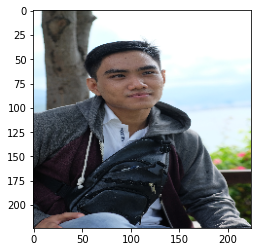

In [24]:
query_path = '/content/drive/MyDrive/Project/FaceRecognition/face_recognize/Bản sao của DSCF5242.JPG'
img = cv2.imread(query_path)
# img = cv2.imread(query_path)
img = cv2.resize(img, (224, 224))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img.dtype, img.shape

In [28]:
embedding_objs = DeepFace.represent(img_path = query_path,model_name='ArcFace')
query_feature = embedding_objs[0]["embedding"]
query_feature = np.asarray(query_feature)

import time
start = time.time()
dist_table = query_dist_table(query_feature, codebooks)
# lookup the distance
dists = np.sum(dist_table[range(64), pqcode], axis=1)
# the numpy indexing trick is equivalent to the following loop approach
n_rows = pqcode.shape[0]
dists = np.zeros(n_rows).astype(np.float32)
for n in range(n_rows):
    for m in range(64):
        dists[n] += dist_table[m][pqcode[n][m]]
k = 5
nearest = np.argsort(dists)[:k]
nearest
print('time query',time.time()-start)

time query 0.006090879440307617


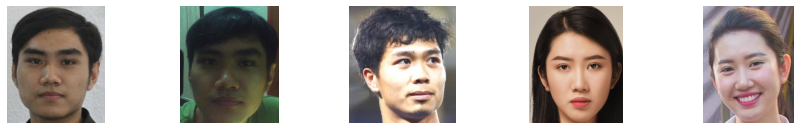

In [26]:
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 6
for i, path in enumerate(nearest, 1):
  img = np.random.randint(10, size=(10,10))
  fig.add_subplot(rows, columns, i)
  plt.imshow(plt.imread(images_path[path]))
  plt.axis("off")
plt.show()